# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

<img src="laneLines_thirdPass.jpg" width="480" alt="Combined Image" />

---
## Overview

### 1. Objective
  - Automatically detect lane lines using an algorithm.

### 2. Applied Techniques
  - Color selection, 
  - Region of interest selection
  - Grayscaling
  - Gaussian smoothing
  - Canny Edge Detection
  - Hough Tranform for line detection.
  
### 3. Description of  pipeline
- Convert input road images to grayscale
- Gaussian smoothing
- Canny Edge Detection
- Marking interested region
- Hough Transsform
- Averaging and fitting lines
- Draw detected lane on input image
---

## Reflection

### 1. Potential shortcomings of current pipeline
One potential shortcoming would be what would happen when the road is not a flat highway.
For example , when we drive on the hill , the marked region will be changed that this pipeline needs modification.
Another shortcoming could be straight line fitting. So this pipeline doen't work well on final curved highway road.

### 2. Improvements
A possible improvement would be to use polynomial fitting than straight line fitting.

---

# Implement pipeline Algorithm

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


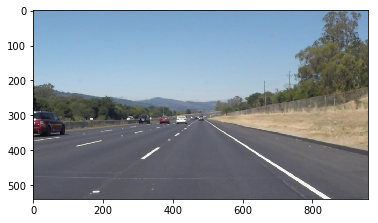

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [271]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(line_image, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # Separate left , right lines
    left_lines = []
    right_lines = []
    for line in lines :
        for x1,y1,x2,y2 in line :
            if x1 < center_x :
                left_lines.append([x1,y1,x2,y2])
            elif x2 > center_x :
                right_lines.append([x1,y1,x2,y2])

    # Averaging slop of left lines
    left_lines_m = []
    for [x1,y1,x2,y2] in left_lines :
        m = (y2-y1)/(x2-x1)
        left_lines_m.append(m)
    left_ave_m = sum(left_lines_m)/float(len(left_lines_m))

    # find left line bottom intersection
    new_lines = []
    sorted_left_lines = sorted(left_lines , key=lambda point : point[0])
    x1,y1,x2,y2 = sorted_left_lines[-1] # use only x2,y2 : left top point
    b = y2- left_ave_m * x2
    x_left_bottom_intersect = int((max_y - b)/ left_ave_m)
    new_lines.append([x_left_bottom_intersect,max_y,x2,y2])

    # Averaging slop of right lines
    right_lines_m = []
    for [x1,y1,x2,y2] in right_lines :
        m = (y2-y1)/(x2-x1)
        right_lines_m.append(m)
    right_ave_m = sum(right_lines_m)/float(len(right_lines_m))

    # find right line bottom intersection
    sorted_right_lines = sorted(right_lines , key=lambda point : point[0])
    x1,y1,x2,y2 = sorted_right_lines[0] # use only x1,y1 : right top point
    b = y1- right_ave_m * x1
    x_right_bottom_intersect = int((max_y - b)/ right_ave_m)
    new_lines.append([x1,y1,x_right_bottom_intersect,max_y])

    # Iterate over the output "new_lines" and draw lines on a blank image
    for x1,y1,x2,y2 in new_lines:
        cv2.line(line_image,(x1,y1),(x2,y2),color,thickness)

#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Test Images

Build your pipeline to work on the images in the directory **"test_images"**  
**You should make sure your pipeline works well on these images before you try the videos.**

In [210]:
import os
image_list = os.listdir("test_images/")
image_list

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

image.shape =
(540, 960, 3)


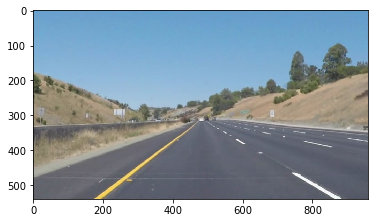

In [251]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Read a image file from 'test_images' folder
test_image_folder_name = "test_images/"
image_file_name = image_list[5]
image = mpimg.imread(test_image_folder_name+image_file_name)
print("image.shape =") #test code
print(image.shape)
plt.imshow(image)

gray.shape =
(540, 960)


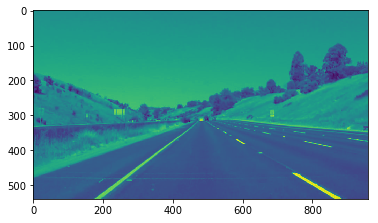

In [252]:
# Covert image to gray
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
print("gray.shape =")
print(gray.shape)
plt.imshow(gray)

blur_gray.shape =
(540, 960)


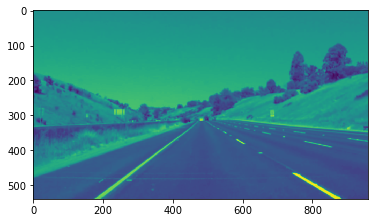

In [253]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
print("blur_gray.shape =")
print(blur_gray.shape)
plt.imshow(blur_gray)

edges.shape =
(540, 960)


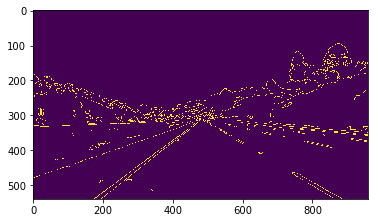

In [254]:
# Define our parameters for Canny and apply
low_threshold = 30
high_threshold = 100
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
print("edges.shape =")
print(edges.shape)
plt.imshow(edges)

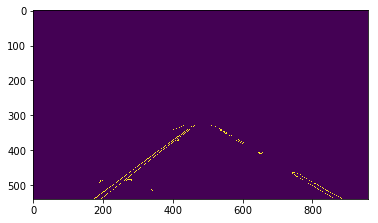

In [255]:
# Cut region of interest
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255 

# This time we are defining a four sided polygon to mask
imshape = image.shape
max_x = imshape[1]
max_y = imshape[0]
center_x = imshape[1]/2
center_y = imshape[0]/2
# vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
vertices = np.array([[(55,imshape[0]),(imshape[1]/2-60, imshape[0]/2+60), (imshape[1]/2+60, imshape[0]/2+60), (imshape[1]-50,imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(image)
plt.imshow(masked_edges)

line_image.shape =
(540, 960, 3)


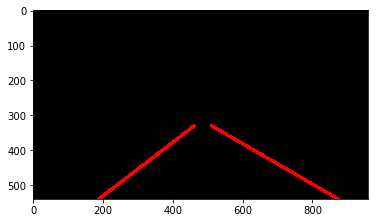

In [272]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 100    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on
print("line_image.shape =")
print(line_image.shape)

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Draw lines on blank image with averaging and extrapolating
draw_lines(line_image, lines)
    
plt.imshow(line_image)

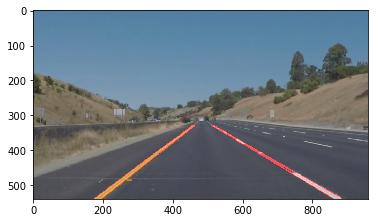

In [270]:
# Draw the lines on the edge image
lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

In [258]:
## save the result image file
saved_file_name = test_image_folder_name + "lane_line_" + image_file_name
cv2.imwrite(saved_file_name,lines_edges)

True

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [259]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [260]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #importing some useful packages
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import cv2
    
    # Covert image to gray
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Define our parameters for Canny and apply
    low_threshold = 30
    high_threshold = 100
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255 

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    max_x = imshape[1]
    max_y = imshape[0]
    center_x = imshape[1]/2
    center_y = imshape[0]/2
    # vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(55,imshape[0]),(imshape[1]/2-60, imshape[0]/2+60), (imshape[1]/2+60, imshape[0]/2+60), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    print("line_image.shape =")
    print(line_image.shape)

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # print(lines)
    # print("lines.shape =")
    # print(lines.shape)

    # Draw lines on blank image with averaging and exrapolating
    draw_lines(line_image, lines)
    
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    

    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [261]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

line_image.shape =
(540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  1%|▏         | 3/222 [00:00<00:08, 26.71it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  3%|▎         | 7/222 [00:00<00:07, 28.58it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  5%|▍         | 11/222 [00:00<00:07, 29.65it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  7%|▋         | 15/222 [00:00<00:06, 30.66it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  9%|▊         | 19/222 [00:00<00:06, 31.05it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 10%|▉         | 22/222 [00:00<00:06, 30.31it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 12%|█▏        | 26/222 [00:00<00:06, 30.73it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 14%|█▎        | 30/222 [00:00<00:06, 31.53it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 15%|█▌        | 34/222 [00:01<00:05, 31.67it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 17%|█▋        | 38/222 [00:01<00:05, 32.29it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 19%|█▉        | 42/222 [00:01<00:05, 31.32it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 21%|██        | 46/222 [00:01<00:05, 30.47it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 23%|██▎       | 50/222 [00:01<00:07, 23.47it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 24%|██▍       | 53/222 [00:01<00:06, 24.42it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 25%|██▌       | 56/222 [00:02<00:07, 21.99it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 27%|██▋       | 59/222 [00:02<00:08, 19.96it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 28%|██▊       | 62/222 [00:02<00:07, 20.81it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 29%|██▉       | 65/222 [00:02<00:07, 19.98it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 31%|███       | 68/222 [00:02<00:08, 19.08it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 32%|███▏      | 71/222 [00:02<00:07, 20.49it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 33%|███▎      | 74/222 [00:02<00:07, 21.08it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 35%|███▍      | 77/222 [00:03<00:06, 21.11it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 36%|███▌      | 80/222 [00:03<00:06, 22.53it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 37%|███▋      | 83/222 [00:03<00:06, 20.19it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 39%|███▊      | 86/222 [00:03<00:06, 21.56it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 40%|████      | 89/222 [00:03<00:06, 19.75it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 41%|████▏     | 92/222 [00:03<00:06, 19.62it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 43%|████▎     | 95/222 [00:03<00:06, 20.02it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 44%|████▍     | 98/222 [00:04<00:06, 19.47it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 45%|████▌     | 100/222 [00:04<00:06, 19.59it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 46%|████▋     | 103/222 [00:04<00:05, 20.90it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 48%|████▊     | 106/222 [00:04<00:05, 22.46it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 49%|████▉     | 109/222 [00:04<00:06, 17.26it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 50%|█████     | 112/222 [00:04<00:05, 18.89it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 52%|█████▏    | 115/222 [00:04<00:05, 19.52it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 53%|█████▎    | 118/222 [00:05<00:05, 20.72it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 55%|█████▍    | 121/222 [00:05<00:05, 19.77it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 56%|█████▌    | 124/222 [00:05<00:05, 19.56it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 57%|█████▋    | 127/222 [00:05<00:04, 20.22it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 59%|█████▊    | 130/222 [00:05<00:04, 20.79it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 60%|█████▉    | 133/222 [00:05<00:04, 20.82it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 61%|██████▏   | 136/222 [00:06<00:04, 19.42it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 63%|██████▎   | 139/222 [00:06<00:04, 19.21it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 64%|██████▎   | 141/222 [00:06<00:04, 19.08it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 65%|██████▍   | 144/222 [00:06<00:03, 21.04it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 66%|██████▌   | 147/222 [00:06<00:03, 22.77it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 68%|██████▊   | 150/222 [00:06<00:03, 20.66it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 69%|██████▉   | 153/222 [00:06<00:03, 17.75it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 70%|███████   | 156/222 [00:07<00:03, 18.79it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 71%|███████   | 158/222 [00:07<00:03, 18.39it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 73%|███████▎  | 161/222 [00:07<00:03, 17.63it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 74%|███████▍  | 164/222 [00:07<00:03, 19.05it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 75%|███████▌  | 167/222 [00:07<00:02, 20.55it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 77%|███████▋  | 170/222 [00:07<00:02, 19.11it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 77%|███████▋  | 172/222 [00:07<00:02, 18.45it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 79%|███████▉  | 175/222 [00:08<00:02, 19.71it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 80%|████████  | 178/222 [00:08<00:02, 19.44it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 81%|████████  | 180/222 [00:08<00:02, 18.56it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 82%|████████▏ | 182/222 [00:08<00:02, 18.33it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 83%|████████▎ | 185/222 [00:08<00:01, 19.46it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 85%|████████▍ | 188/222 [00:08<00:01, 20.23it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 86%|████████▌ | 191/222 [00:08<00:01, 20.06it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 87%|████████▋ | 194/222 [00:08<00:01, 19.64it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 89%|████████▊ | 197/222 [00:09<00:01, 20.57it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 90%|█████████ | 200/222 [00:09<00:01, 21.63it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 91%|█████████▏| 203/222 [00:09<00:00, 21.01it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 93%|█████████▎| 206/222 [00:09<00:00, 18.82it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 94%|█████████▎| 208/222 [00:09<00:00, 18.50it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 95%|█████████▍| 210/222 [00:09<00:00, 17.95it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 95%|█████████▌| 212/222 [00:09<00:00, 18.39it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 96%|█████████▋| 214/222 [00:10<00:00, 18.12it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 98%|█████████▊| 217/222 [00:10<00:00, 19.44it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 99%|█████████▊| 219/222 [00:10<00:00, 16.86it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


100%|█████████▉| 221/222 [00:10<00:00, 16.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 11.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [262]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [263]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

line_image.shape =
(540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  1%|          | 4/682 [00:00<00:21, 32.25it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  1%|          | 8/682 [00:00<00:20, 33.52it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  2%|▏         | 12/682 [00:00<00:19, 34.21it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  2%|▏         | 16/682 [00:00<00:19, 34.62it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  3%|▎         | 20/682 [00:00<00:19, 34.65it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  4%|▎         | 24/682 [00:00<00:18, 35.02it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  4%|▍         | 28/682 [00:00<00:19, 33.64it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  5%|▍         | 33/682 [00:00<00:18, 35.40it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  5%|▌         | 37/682 [00:01<00:19, 32.98it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  6%|▌         | 41/682 [00:01<00:19, 33.24it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  7%|▋         | 45/682 [00:01<00:19, 33.09it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  7%|▋         | 49/682 [00:01<00:21, 29.37it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  8%|▊         | 52/682 [00:01<00:21, 28.84it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  8%|▊         | 55/682 [00:01<00:24, 25.83it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  9%|▊         | 58/682 [00:01<00:27, 22.98it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  9%|▉         | 61/682 [00:02<00:32, 19.29it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


  9%|▉         | 64/682 [00:02<00:30, 20.45it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 10%|▉         | 67/682 [00:02<00:28, 21.23it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 10%|█         | 70/682 [00:02<00:34, 17.73it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 11%|█         | 73/682 [00:02<00:33, 18.31it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 11%|█         | 76/682 [00:02<00:29, 20.54it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 12%|█▏        | 79/682 [00:03<00:35, 16.84it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 12%|█▏        | 81/682 [00:03<00:35, 16.70it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 12%|█▏        | 84/682 [00:03<00:31, 18.78it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 13%|█▎        | 87/682 [00:03<00:34, 17.16it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 13%|█▎        | 91/682 [00:03<00:30, 19.18it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 14%|█▍        | 94/682 [00:03<00:33, 17.51it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 14%|█▍        | 96/682 [00:04<00:35, 16.38it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 15%|█▍        | 99/682 [00:04<00:33, 17.48it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 15%|█▍        | 102/682 [00:04<00:31, 18.55it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 15%|█▌        | 104/682 [00:04<00:34, 16.63it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 16%|█▌        | 106/682 [00:04<00:33, 17.40it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 16%|█▌        | 109/682 [00:04<00:30, 18.82it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 16%|█▋        | 111/682 [00:04<00:33, 16.94it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 17%|█▋        | 115/682 [00:04<00:28, 20.11it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 17%|█▋        | 118/682 [00:05<00:30, 18.70it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 18%|█▊        | 121/682 [00:05<00:29, 19.17it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 18%|█▊        | 124/682 [00:05<00:31, 17.78it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 19%|█▊        | 127/682 [00:05<00:28, 19.80it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 19%|█▉        | 130/682 [00:05<00:25, 21.69it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 20%|█▉        | 133/682 [00:05<00:25, 21.23it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 20%|█▉        | 136/682 [00:06<00:29, 18.39it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 20%|██        | 138/682 [00:06<00:29, 18.56it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 21%|██        | 141/682 [00:06<00:29, 18.38it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 21%|██        | 144/682 [00:06<00:28, 18.62it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 21%|██▏       | 146/682 [00:06<00:31, 17.25it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 22%|██▏       | 148/682 [00:06<00:30, 17.42it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 22%|██▏       | 151/682 [00:06<00:29, 17.73it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 23%|██▎       | 155/682 [00:07<00:28, 18.25it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 23%|██▎       | 159/682 [00:07<00:27, 19.19it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 24%|██▍       | 162/682 [00:07<00:25, 20.29it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 24%|██▍       | 165/682 [00:07<00:26, 19.42it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 24%|██▍       | 167/682 [00:07<00:27, 18.75it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 25%|██▌       | 171/682 [00:07<00:23, 21.48it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 26%|██▌       | 174/682 [00:08<00:24, 20.87it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 26%|██▌       | 177/682 [00:08<00:25, 19.45it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 26%|██▋       | 180/682 [00:08<00:23, 21.05it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 27%|██▋       | 183/682 [00:08<00:25, 19.59it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 27%|██▋       | 186/682 [00:08<00:24, 20.24it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 28%|██▊       | 189/682 [00:08<00:23, 21.29it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 28%|██▊       | 192/682 [00:08<00:25, 18.97it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 28%|██▊       | 194/682 [00:09<00:25, 18.97it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 29%|██▉       | 198/682 [00:09<00:23, 20.44it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 29%|██▉       | 201/682 [00:09<00:24, 19.86it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 30%|██▉       | 204/682 [00:09<00:22, 20.99it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 30%|███       | 207/682 [00:09<00:21, 22.19it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 31%|███       | 210/682 [00:09<00:20, 22.60it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 31%|███       | 213/682 [00:09<00:25, 18.51it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 32%|███▏      | 216/682 [00:10<00:22, 20.31it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 32%|███▏      | 219/682 [00:10<00:21, 21.88it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 33%|███▎      | 222/682 [00:10<00:21, 21.22it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 33%|███▎      | 225/682 [00:10<00:25, 18.23it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 33%|███▎      | 228/682 [00:10<00:24, 18.88it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 34%|███▍      | 232/682 [00:10<00:20, 21.57it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 34%|███▍      | 235/682 [00:11<00:22, 20.06it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 35%|███▍      | 238/682 [00:11<00:20, 22.01it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 35%|███▌      | 241/682 [00:11<00:20, 21.08it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 36%|███▌      | 244/682 [00:11<00:22, 19.14it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 36%|███▌      | 247/682 [00:11<00:20, 21.09it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 37%|███▋      | 250/682 [00:11<00:20, 21.25it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 37%|███▋      | 253/682 [00:11<00:19, 21.54it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 38%|███▊      | 256/682 [00:11<00:19, 22.23it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 38%|███▊      | 259/682 [00:12<00:21, 20.02it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 38%|███▊      | 262/682 [00:12<00:21, 19.17it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 39%|███▉      | 265/682 [00:12<00:19, 21.30it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 39%|███▉      | 268/682 [00:12<00:26, 15.72it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 40%|███▉      | 272/682 [00:12<00:22, 17.99it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 40%|████      | 275/682 [00:13<00:20, 19.71it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 41%|████      | 278/682 [00:13<00:19, 21.13it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 41%|████      | 281/682 [00:13<00:19, 20.76it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 42%|████▏     | 284/682 [00:13<00:18, 21.01it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 42%|████▏     | 287/682 [00:13<00:21, 18.15it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 43%|████▎     | 290/682 [00:13<00:19, 19.66it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 43%|████▎     | 293/682 [00:13<00:18, 20.58it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 43%|████▎     | 296/682 [00:14<00:22, 16.83it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 44%|████▍     | 300/682 [00:14<00:19, 19.65it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 44%|████▍     | 303/682 [00:14<00:20, 18.73it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 45%|████▍     | 306/682 [00:14<00:20, 18.10it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 45%|████▌     | 308/682 [00:14<00:20, 18.01it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 46%|████▌     | 312/682 [00:14<00:18, 19.68it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 46%|████▌     | 315/682 [00:15<00:20, 17.77it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 47%|████▋     | 318/682 [00:15<00:19, 18.54it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 47%|████▋     | 322/682 [00:15<00:16, 21.42it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 48%|████▊     | 325/682 [00:15<00:17, 20.05it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 48%|████▊     | 328/682 [00:15<00:16, 21.22it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 49%|████▊     | 331/682 [00:15<00:21, 16.55it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 49%|████▉     | 335/682 [00:16<00:17, 19.46it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 50%|████▉     | 338/682 [00:16<00:16, 20.84it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 50%|█████     | 341/682 [00:16<00:15, 21.84it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 50%|█████     | 344/682 [00:16<00:14, 22.90it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 51%|█████     | 347/682 [00:16<00:15, 21.42it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 51%|█████▏    | 350/682 [00:16<00:17, 18.70it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 52%|█████▏    | 353/682 [00:16<00:17, 19.16it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 52%|█████▏    | 356/682 [00:17<00:15, 21.20it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 53%|█████▎    | 359/682 [00:17<00:14, 22.55it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 53%|█████▎    | 362/682 [00:17<00:15, 20.44it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 54%|█████▎    | 365/682 [00:17<00:14, 22.52it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 54%|█████▍    | 368/682 [00:17<00:14, 22.30it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 54%|█████▍    | 371/682 [00:17<00:14, 22.09it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 55%|█████▍    | 374/682 [00:17<00:15, 20.30it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 55%|█████▌    | 377/682 [00:18<00:15, 19.17it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 56%|█████▌    | 381/682 [00:18<00:13, 22.22it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 56%|█████▋    | 384/682 [00:18<00:15, 19.82it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 57%|█████▋    | 387/682 [00:18<00:15, 18.66it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 57%|█████▋    | 391/682 [00:18<00:14, 19.45it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 58%|█████▊    | 394/682 [00:18<00:13, 20.75it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 58%|█████▊    | 397/682 [00:19<00:15, 18.81it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 59%|█████▊    | 399/682 [00:19<00:16, 17.32it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 59%|█████▉    | 401/682 [00:19<00:16, 17.51it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 59%|█████▉    | 404/682 [00:19<00:14, 19.13it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 60%|█████▉    | 407/682 [00:19<00:13, 20.21it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 60%|██████    | 410/682 [00:19<00:14, 18.29it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 61%|██████    | 413/682 [00:19<00:13, 19.33it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 61%|██████    | 416/682 [00:20<00:15, 17.57it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 61%|██████▏   | 419/682 [00:20<00:15, 16.81it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 62%|██████▏   | 423/682 [00:20<00:13, 18.57it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 62%|██████▏   | 426/682 [00:20<00:12, 20.27it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 63%|██████▎   | 429/682 [00:20<00:13, 19.34it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 63%|██████▎   | 432/682 [00:20<00:12, 20.70it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 64%|██████▍   | 435/682 [00:21<00:13, 18.51it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 64%|██████▍   | 437/682 [00:21<00:14, 17.14it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 65%|██████▍   | 440/682 [00:21<00:13, 18.48it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 65%|██████▍   | 443/682 [00:21<00:12, 19.66it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 65%|██████▌   | 446/682 [00:21<00:12, 19.15it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 66%|██████▌   | 449/682 [00:21<00:10, 21.41it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 66%|██████▋   | 452/682 [00:21<00:09, 23.29it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 67%|██████▋   | 455/682 [00:22<00:11, 20.24it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 67%|██████▋   | 458/682 [00:22<00:11, 19.17it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 68%|██████▊   | 461/682 [00:22<00:11, 19.36it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 68%|██████▊   | 464/682 [00:22<00:10, 20.97it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 69%|██████▊   | 468/682 [00:22<00:09, 23.59it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 69%|██████▉   | 471/682 [00:22<00:10, 20.09it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 70%|██████▉   | 474/682 [00:22<00:10, 20.32it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 70%|██████▉   | 477/682 [00:23<00:12, 16.52it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 71%|███████   | 481/682 [00:23<00:10, 19.38it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 71%|███████   | 484/682 [00:23<00:10, 18.90it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 71%|███████▏  | 487/682 [00:23<00:10, 19.10it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 72%|███████▏  | 490/682 [00:23<00:09, 19.75it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 72%|███████▏  | 493/682 [00:23<00:11, 17.07it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 73%|███████▎  | 497/682 [00:24<00:09, 19.56it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 73%|███████▎  | 500/682 [00:24<00:09, 18.71it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 74%|███████▍  | 503/682 [00:24<00:08, 19.92it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 74%|███████▍  | 506/682 [00:24<00:09, 18.62it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 74%|███████▍  | 508/682 [00:24<00:09, 17.48it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 75%|███████▍  | 511/682 [00:24<00:09, 18.92it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 75%|███████▌  | 514/682 [00:25<00:08, 20.20it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 76%|███████▌  | 517/682 [00:25<00:08, 20.33it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 76%|███████▌  | 520/682 [00:25<00:08, 18.77it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 77%|███████▋  | 522/682 [00:25<00:09, 17.21it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 77%|███████▋  | 524/682 [00:25<00:09, 17.39it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 77%|███████▋  | 528/682 [00:25<00:08, 18.79it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 78%|███████▊  | 531/682 [00:25<00:08, 18.37it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 78%|███████▊  | 534/682 [00:26<00:07, 20.23it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 79%|███████▊  | 537/682 [00:26<00:07, 19.02it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 79%|███████▉  | 540/682 [00:26<00:07, 20.12it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 80%|███████▉  | 543/682 [00:26<00:08, 16.86it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 80%|███████▉  | 545/682 [00:26<00:07, 17.49it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 80%|████████  | 547/682 [00:26<00:07, 17.27it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 81%|████████  | 550/682 [00:26<00:06, 19.10it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 81%|████████  | 554/682 [00:27<00:06, 19.44it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 82%|████████▏ | 557/682 [00:27<00:05, 21.44it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 82%|████████▏ | 561/682 [00:27<00:05, 22.46it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 83%|████████▎ | 564/682 [00:27<00:05, 21.11it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 83%|████████▎ | 567/682 [00:27<00:05, 20.50it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 84%|████████▎ | 570/682 [00:27<00:06, 17.63it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 84%|████████▍ | 573/682 [00:28<00:05, 19.90it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 84%|████████▍ | 576/682 [00:28<00:05, 21.19it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 85%|████████▍ | 579/682 [00:28<00:05, 19.20it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 85%|████████▌ | 582/682 [00:28<00:05, 19.68it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 86%|████████▌ | 585/682 [00:28<00:05, 18.18it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 86%|████████▌ | 588/682 [00:28<00:04, 19.10it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 87%|████████▋ | 590/682 [00:29<00:06, 14.24it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 87%|████████▋ | 593/682 [00:29<00:05, 16.78it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 87%|████████▋ | 596/682 [00:29<00:05, 17.12it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 88%|████████▊ | 600/682 [00:29<00:04, 19.14it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 88%|████████▊ | 603/682 [00:29<00:04, 16.27it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 89%|████████▊ | 605/682 [00:29<00:04, 16.58it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 89%|████████▉ | 608/682 [00:29<00:03, 19.09it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 90%|████████▉ | 611/682 [00:30<00:03, 19.05it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 90%|█████████ | 614/682 [00:30<00:03, 18.85it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 90%|█████████ | 617/682 [00:30<00:03, 19.80it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 91%|█████████ | 620/682 [00:30<00:03, 18.09it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 91%|█████████ | 622/682 [00:30<00:03, 16.73it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 92%|█████████▏| 626/682 [00:30<00:02, 19.60it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 92%|█████████▏| 629/682 [00:31<00:02, 20.17it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 93%|█████████▎| 632/682 [00:31<00:02, 17.55it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 93%|█████████▎| 634/682 [00:31<00:02, 18.05it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 93%|█████████▎| 636/682 [00:31<00:02, 17.98it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 94%|█████████▎| 639/682 [00:31<00:02, 20.29it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 94%|█████████▍| 643/682 [00:31<00:01, 21.16it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 95%|█████████▍| 646/682 [00:31<00:01, 18.56it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 95%|█████████▌| 650/682 [00:32<00:01, 20.85it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 96%|█████████▌| 653/682 [00:32<00:01, 21.48it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 96%|█████████▌| 656/682 [00:32<00:01, 20.37it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 97%|█████████▋| 659/682 [00:32<00:01, 16.57it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 97%|█████████▋| 661/682 [00:32<00:01, 16.97it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 97%|█████████▋| 664/682 [00:32<00:01, 16.61it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 98%|█████████▊| 667/682 [00:33<00:00, 18.84it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 98%|█████████▊| 670/682 [00:33<00:00, 19.75it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 99%|█████████▉| 674/682 [00:33<00:00, 22.39it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


 99%|█████████▉| 677/682 [00:33<00:00, 18.51it/s]

line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)
line_image.shape =
(540, 960, 3)


100%|█████████▉| 681/682 [00:33<00:00, 21.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 34.7 s


In [264]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [265]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

line_image.shape =
(720, 1280, 3)
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  1%|          | 2/251 [00:00<00:15, 16.38it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  2%|▏         | 4/251 [00:00<00:14, 16.75it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  2%|▏         | 6/251 [00:00<00:14, 17.44it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  3%|▎         | 8/251 [00:00<00:13, 17.97it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  4%|▍         | 10/251 [00:00<00:13, 18.45it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  5%|▍         | 12/251 [00:00<00:13, 17.78it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  6%|▌         | 14/251 [00:00<00:14, 16.46it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  6%|▋         | 16/251 [00:00<00:13, 16.92it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  7%|▋         | 18/251 [00:01<00:14, 16.64it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  8%|▊         | 20/251 [00:01<00:13, 17.36it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


  9%|▉         | 22/251 [00:01<00:13, 16.89it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 10%|▉         | 24/251 [00:01<00:12, 17.55it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 10%|█         | 26/251 [00:01<00:13, 16.56it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 11%|█         | 28/251 [00:01<00:13, 17.08it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 12%|█▏        | 30/251 [00:01<00:12, 17.70it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 13%|█▎        | 32/251 [00:01<00:12, 17.50it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 14%|█▎        | 34/251 [00:01<00:12, 17.87it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 14%|█▍        | 36/251 [00:02<00:12, 17.90it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 15%|█▌        | 38/251 [00:02<00:11, 18.16it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 16%|█▌        | 40/251 [00:02<00:11, 18.15it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 17%|█▋        | 42/251 [00:02<00:11, 18.14it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 18%|█▊        | 44/251 [00:02<00:11, 17.53it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 18%|█▊        | 46/251 [00:02<00:11, 17.84it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 19%|█▉        | 48/251 [00:02<00:15, 13.03it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 20%|█▉        | 50/251 [00:03<00:16, 12.31it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 21%|██        | 52/251 [00:03<00:15, 12.47it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 22%|██▏       | 54/251 [00:03<00:17, 11.57it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 22%|██▏       | 56/251 [00:03<00:15, 12.48it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 23%|██▎       | 58/251 [00:03<00:17, 11.23it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 24%|██▍       | 60/251 [00:03<00:15, 12.22it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 25%|██▍       | 62/251 [00:04<00:17, 10.87it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 25%|██▌       | 64/251 [00:04<00:16, 11.33it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 26%|██▋       | 66/251 [00:04<00:16, 11.31it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 27%|██▋       | 68/251 [00:04<00:15, 11.48it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 28%|██▊       | 70/251 [00:04<00:15, 11.51it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 29%|██▊       | 72/251 [00:04<00:15, 11.76it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 29%|██▉       | 74/251 [00:05<00:15, 11.69it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 30%|███       | 76/251 [00:05<00:14, 12.11it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 31%|███       | 78/251 [00:05<00:14, 11.78it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 32%|███▏      | 80/251 [00:05<00:14, 11.71it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 33%|███▎      | 82/251 [00:05<00:14, 11.83it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 33%|███▎      | 84/251 [00:05<00:14, 11.69it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 34%|███▍      | 86/251 [00:06<00:14, 11.74it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 35%|███▌      | 88/251 [00:06<00:14, 11.47it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 36%|███▌      | 90/251 [00:06<00:14, 11.05it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 37%|███▋      | 92/251 [00:06<00:15, 10.21it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 37%|███▋      | 94/251 [00:06<00:15, 10.27it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 38%|███▊      | 96/251 [00:07<00:14, 10.93it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 39%|███▉      | 98/251 [00:07<00:14, 10.67it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 40%|███▉      | 100/251 [00:07<00:15,  9.98it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 41%|████      | 102/251 [00:07<00:13, 11.14it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 41%|████▏     | 104/251 [00:07<00:12, 11.61it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 42%|████▏     | 106/251 [00:08<00:15,  9.41it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 43%|████▎     | 108/251 [00:08<00:14, 10.11it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 44%|████▍     | 110/251 [00:08<00:15,  9.37it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 45%|████▍     | 112/251 [00:08<00:15,  9.24it/s]

line_image.shape =
(720, 1280, 3)


 45%|████▌     | 113/251 [00:08<00:15,  8.99it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 46%|████▌     | 115/251 [00:09<00:13, 10.15it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 47%|████▋     | 117/251 [00:09<00:13,  9.94it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 47%|████▋     | 119/251 [00:09<00:12, 10.19it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 48%|████▊     | 121/251 [00:09<00:12, 10.41it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 49%|████▉     | 123/251 [00:09<00:11, 11.55it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 50%|████▉     | 125/251 [00:10<00:12,  9.85it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 51%|█████     | 127/251 [00:10<00:14,  8.66it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 51%|█████▏    | 129/251 [00:10<00:12,  9.73it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 52%|█████▏    | 131/251 [00:10<00:10, 11.36it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 53%|█████▎    | 133/251 [00:10<00:12,  9.54it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 54%|█████▍    | 135/251 [00:11<00:11, 10.19it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 55%|█████▍    | 137/251 [00:11<00:12,  8.91it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 55%|█████▌    | 139/251 [00:11<00:11,  9.49it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 56%|█████▌    | 141/251 [00:11<00:11,  9.36it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 57%|█████▋    | 143/251 [00:11<00:12,  8.86it/s]

line_image.shape =
(720, 1280, 3)


 57%|█████▋    | 144/251 [00:12<00:12,  8.90it/s]

line_image.shape =
(720, 1280, 3)


 58%|█████▊    | 145/251 [00:12<00:11,  9.11it/s]

line_image.shape =
(720, 1280, 3)


 58%|█████▊    | 146/251 [00:12<00:12,  8.61it/s]

line_image.shape =
(720, 1280, 3)


 59%|█████▊    | 147/251 [00:12<00:11,  8.90it/s]

line_image.shape =
(720, 1280, 3)


 59%|█████▉    | 148/251 [00:12<00:11,  8.70it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 60%|█████▉    | 150/251 [00:12<00:10,  9.39it/s]

line_image.shape =
(720, 1280, 3)


 60%|██████    | 151/251 [00:12<00:13,  7.36it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 61%|██████    | 153/251 [00:13<00:11,  8.70it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 62%|██████▏   | 155/251 [00:13<00:10,  9.01it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 63%|██████▎   | 157/251 [00:13<00:10,  9.10it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 63%|██████▎   | 159/251 [00:13<00:09,  9.26it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 64%|██████▍   | 161/251 [00:13<00:08, 10.16it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 65%|██████▍   | 163/251 [00:14<00:09,  9.56it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 66%|██████▌   | 165/251 [00:14<00:10,  8.45it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 67%|██████▋   | 167/251 [00:14<00:08,  9.43it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 67%|██████▋   | 169/251 [00:14<00:07, 10.62it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 68%|██████▊   | 171/251 [00:14<00:07, 10.62it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 69%|██████▉   | 173/251 [00:15<00:07,  9.91it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 70%|██████▉   | 175/251 [00:15<00:08,  8.72it/s]

line_image.shape =
(720, 1280, 3)


 70%|███████   | 176/251 [00:15<00:08,  8.86it/s]

line_image.shape =
(720, 1280, 3)


 71%|███████   | 177/251 [00:15<00:08,  9.11it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 71%|███████▏  | 179/251 [00:15<00:06, 10.32it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 72%|███████▏  | 181/251 [00:16<00:09,  7.25it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 73%|███████▎  | 183/251 [00:16<00:08,  8.11it/s]

line_image.shape =
(720, 1280, 3)


 73%|███████▎  | 184/251 [00:16<00:09,  7.21it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 74%|███████▍  | 186/251 [00:16<00:07,  8.21it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 75%|███████▍  | 188/251 [00:16<00:07,  8.68it/s]

line_image.shape =
(720, 1280, 3)


 75%|███████▌  | 189/251 [00:17<00:08,  7.40it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 76%|███████▌  | 191/251 [00:17<00:07,  8.47it/s]

line_image.shape =
(720, 1280, 3)


 76%|███████▋  | 192/251 [00:17<00:06,  8.62it/s]

line_image.shape =
(720, 1280, 3)


 77%|███████▋  | 193/251 [00:17<00:06,  8.72it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 78%|███████▊  | 195/251 [00:17<00:06,  8.34it/s]

line_image.shape =
(720, 1280, 3)


 78%|███████▊  | 196/251 [00:17<00:06,  8.17it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 79%|███████▉  | 198/251 [00:18<00:07,  7.54it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 80%|███████▉  | 200/251 [00:18<00:05,  8.90it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 80%|████████  | 202/251 [00:18<00:04, 10.60it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 81%|████████▏ | 204/251 [00:18<00:04, 11.38it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 82%|████████▏ | 206/251 [00:18<00:04,  9.52it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 83%|████████▎ | 208/251 [00:18<00:04, 10.38it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 84%|████████▎ | 210/251 [00:19<00:04,  9.56it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 84%|████████▍ | 212/251 [00:19<00:03, 10.65it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 85%|████████▌ | 214/251 [00:19<00:03,  9.45it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 86%|████████▌ | 216/251 [00:19<00:03,  8.91it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 87%|████████▋ | 218/251 [00:20<00:03,  9.38it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 88%|████████▊ | 220/251 [00:20<00:03, 10.07it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 88%|████████▊ | 222/251 [00:20<00:02,  9.89it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 89%|████████▉ | 224/251 [00:20<00:02, 10.12it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 90%|█████████ | 226/251 [00:20<00:02, 10.87it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 91%|█████████ | 228/251 [00:21<00:02,  9.63it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 92%|█████████▏| 230/251 [00:21<00:02,  9.68it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 92%|█████████▏| 232/251 [00:21<00:01, 10.24it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 93%|█████████▎| 234/251 [00:21<00:01, 10.66it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 94%|█████████▍| 236/251 [00:21<00:01, 10.20it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 95%|█████████▍| 238/251 [00:22<00:01,  9.40it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 96%|█████████▌| 240/251 [00:22<00:01, 10.20it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 96%|█████████▋| 242/251 [00:22<00:00,  9.91it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 97%|█████████▋| 244/251 [00:22<00:00, 10.73it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 98%|█████████▊| 246/251 [00:22<00:00, 10.08it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


 99%|█████████▉| 248/251 [00:22<00:00, 11.19it/s]

line_image.shape =
(720, 1280, 3)
line_image.shape =
(720, 1280, 3)


100%|█████████▉| 250/251 [00:23<00:00, 11.67it/s]

line_image.shape =
(720, 1280, 3)


100%|██████████| 251/251 [00:23<00:00, 10.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 25.4 s


In [266]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Reflection
### 1. Description of  pipeline.
- Converted the images to grayscale
- Gaussian smoothing
- Canny Edge Detection
- Marking interested region
- Hough Transsform
- Averaging and extrapolating lines
- Draw image

In order to draw a single line on the left and right lanes, I modified the draw_lines() function by
separating left & right lines --> find average slop of left & right line --> draw single line using a point and average slop.

### 2. Potential shortcomings of current pipeline
One potential shortcoming would be what would happen when the road is not a flat highway.
For example , when we drive on the hill , the marked region will be changed that this pipeline needs modification.
Another shortcoming could be straight line fitting. So this pipeline doen't work well on final curved highway road.

### 3. Improvements
A possible improvement would be to use polynomial fitting than straight line fitting.